## Tensorflow Probability - Probabilistic Deep Learning   
### Day 8/100 Days of TensorFlow Probability  

Yesterday we looked at the performance of tensorflow probability (tfp) and the performance of tensor operations blew me away! It was a big day. It really cemented for me that I am all in on this - let's learn it and learn it good (to steal an idiom from [Learn you a Haskell for great good](http://learnyouahaskell.com/)).  

So today, we are going to address some of our earlier challenges which we haven't solved using the `tfp.glm.fit()` method. Specifically, let's explore ways of getting the "uncertainties" for free (though perhaps we solved that yesterday) and let's address the heteroscedasticity in our dataset.

I'm not going full-tfp yet. Instead today, we are going to follow the case study on [Regression with Probabilistic Layers](https://medium.com/tensorflow/regression-with-probabilistic-layers-in-tensorflow-probability-e46ff5d37baf) which uses probabilistic layers. It's nice and simple and it tackles the two problems we currently have not solved. So, there isn't really anything "orignal" in this, we are simply going to apply their tutorial to our data though we will expand on certain areas in ways that help me understand what is going on.


### Example data  

As always, let's start with some data. I am going to modify our simulation a little this time around. We are still going to have seasonality, noise and heteroscedasticity. I am also going to add a longer positive trend.

[[ 0.40166528]
 [ 0.29879191]
 [-0.09915495]
 [ 2.5320589 ]]


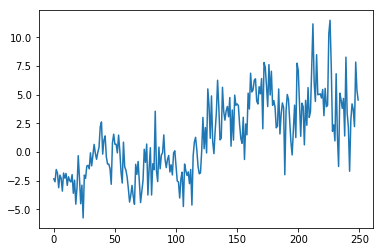

In [6]:
import collections
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

try:
  tf.compat.v1.enable_eager_execution()
except ValueError:
  pass

import matplotlib.pyplot as plt

from __future__ import print_function


np.random.seed(1704)

# simulate 300 observations which follow a rough seasonal pattern
N = 250
X = np.transpose(
    np.matrix([
        np.ones(N),                                           # bias term 
        np.random.normal(2.7, 3, N),                          # feature one
        np.random.normal(-1.5, 1, N),                         # feature two
        0.45*np.cos(np.linspace(1, N, N) / 7.0) + \
            0.55*np.sin(np.linspace(1, N, N) / 21.0)          # seasonalilty
]))

# "ground truth" effects
# these are the parameters that we will attempt to recover
betas = np.matrix([
    np.random.normal(0.4, 0.1, N),           # THE INTERCEPT
    np.random.normal(0.3, 0.075, N),         # effect of feature one
    np.random.normal(-0.1, 0.025, N),        # effect of feature two
    np.random.normal(2.5, 0.75, N)           # the seasonal effect
])
ground_truth_betas = np.mean(betas, axis=1)
print(ground_truth_betas)

# create a response variable, which is a function of our Xs + noise
y = np.mean(np.matmul(X, betas), axis=1)
y += np.random.normal(0, [0.15*np.sqrt(x) for x in range(N)], N)[:,np.newaxis]
y = tf.convert_to_tensor(y.reshape(N,)).numpy()[0]
y += np.linspace(-5, 5, num = N)           # the growing trend

plt.plot(range(N), y)
plt.show()

This data looks good. It's debatable whether there is a continuous increasing trend, or perhaps whether there are two distrinct states (a lower state from `t ~= 1..125` and a higher state from `t ~= 125..250`). But the data looks great.


## Case 1: Simple Linear Regression  

Here is our first case, a simple linear regression using keras and a probabilistic layer. This code is directly from the tutorial, slightly modified to work with tensorflow 2.0.

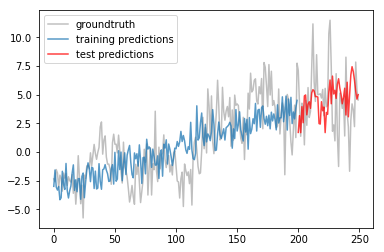

In [22]:
negloglik = lambda y, p_y: -p_y.log_prob(y)


# divide my data into train and test
xtrain = np.arange(200.0)
xtest = np.arange(200.0, 250.0)
ytrain, ytest = [y[:200], y[200:]]

# Define the model
# This is a univariate timeseries prediction problem. Hence, a Dense layer
# with a single node.
# The data is assumed to be normally distributed, hence the final layer
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
# In this case, x is simply a sequence from 1..250
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model.fit(xtrain, ytrain, epochs=500, verbose=False)

# Make predictions.
# NOTE: xtest needs to be a matrix hence, the code below.
yhat_train = model(xtrain[...,np.newaxis])
yhat_test = model(xtest[...,np.newaxis])

# Visualise the results
plt.plot(range(250), y, color='grey', alpha=0.5, label = "groundtruth")
plt.plot(xtrain, yhat_train.sample(), alpha=0.75, label = 'training predictions')
plt.plot(xtest, yhat_test.sample(), alpha=0.75, color = 'red', label = 'test predictions')
plt.legend()
plt.show()

**Key points**  

  - The model has done a really good job of picking the longer trend and the variance in this. Though, it hasn't fitted the seasonality.   
  - note that the predictions *do not return point estimates*, it returns *a distribution(!!!)*. This is super handy, because we can get a sense of the variability by sampling from the distribution. Let's show this below:



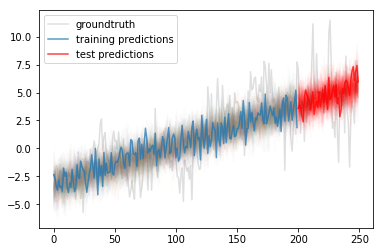

In [26]:
# Visualise the results
plt.plot(range(250), y, color='grey', alpha=0.25, label = "groundtruth")

# display 100 random samples from our model
for i in range(100):
  plt.plot(xtrain, yhat_train.sample(), alpha=0.025)
  plt.plot(xtest, yhat_test.sample(), alpha=0.025, color = 'red') 
  
# emphasise one random sample
plt.plot(xtrain, yhat_train.sample(), alpha=0.75, label = 'training predictions')
plt.plot(xtest, yhat_test.sample(), alpha=0.75, color = 'red', label = 'test predictions')

plt.legend()
plt.show()

That's a little messy - but you can see the "uncertainty" represented by what looks like shaded areas.  

### Case 2: Modeling with covariates  

Let's add the seasonality covariate to this model and see if we can capture this as well. Note, that our model specification doesn't need to change, we don't need to increase the number of nodes in the Dense layer just because we have two features now. The dense layer is our OUTPUT layer, which then gets passed to the distribution.

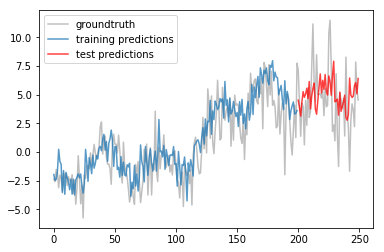

In [38]:
# divide my data into train and test
xtrain = np.hstack([np.arange(200.0)[...,np.newaxis], X[:200, 3]])
xtest = np.hstack([np.arange(200.0,250.0)[...,np.newaxis], X[200:, 3]])
ytrain, ytest = [y[:200], y[200:]]


# Define the model
# This is a univariate timeseries prediction problem. Hence, a Dense layer
# with a single node. This doesn't change just because we have two features now
# The data is assumed to be normally distributed, hence the final layer
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
# In this case, x is simply a sequence from 1..250
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model.fit(xtrain, ytrain, epochs=500, verbose=False)

# Make predictions.
yhat_train = model(xtrain)
yhat_test = model(xtest)

# Visualise the results
plt.plot(range(250), y, color='grey', alpha=0.5, label = "groundtruth")
plt.plot(range(200), yhat_train.sample(), alpha=0.75, label = 'training predictions')
plt.plot(range(200,250), yhat_test.sample(), alpha=0.75, color = 'red', label = 'test predictions')
plt.legend()
plt.show()

This is bang on. Very, very hard to fault this. Though perhaps there is a slight lag between the observed data and the predictions? It's hard to see and I might be reading to much into this. 

Again, let's add in a few simulated draws to get a sense of the uncertainty:

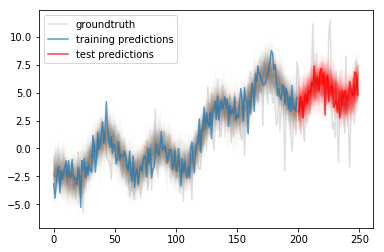

In [39]:
# Visualise the results
plt.plot(range(250), y, color='grey', alpha=0.25, label = "groundtruth")

# display 100 random samples from our model
for i in range(100):
  plt.plot(range(200), yhat_train.sample(), alpha=0.025)
  plt.plot(range(200,250), yhat_test.sample(), alpha=0.025, color = 'red') 
  
# emphasise one random sample
plt.plot(range(200), yhat_train.sample(), alpha=0.75, label = 'training predictions')
plt.plot(range(200,250), yhat_test.sample(), alpha=0.75, color = 'red', label = 'test predictions')

plt.legend()
plt.show()

This is brilliant. Very, very hard to fault this.

### Case 3: Incorporating heteroscedasticity  

This leaves just one problem to solve now, that of heteroscedasticity. Thankfully, the tutorial addresses this for us. Let's give it a whirl...

We need to add an extra node (parameter) to our Dense layer now, because we are going to model the response (y) and the heteroscedasticity. Otherwise though, there are very few changes.

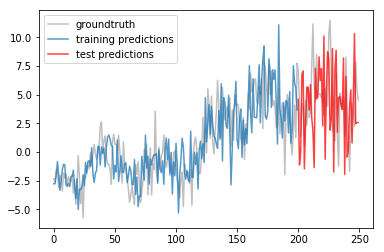

In [41]:
# Define the model
# Add a second output parameter, which will be the heteroscedasticity
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1 + 1),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(
            loc = t[...,:1],
            scale = 1e-3 + tf.math.softplus(0.05 * t[...,1:])
        )
    )
])


# Do inference.
# In this case, x is simply a sequence from 1..250
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model.fit(xtrain, ytrain, epochs=500, verbose=False)

# Make predictions.
yhat_train = model(xtrain)
yhat_test = model(xtest)

# Visualise the results
plt.plot(range(250), y, color='grey', alpha=0.5, label = "groundtruth")
plt.plot(range(200), yhat_train.sample(), alpha=0.75, label = 'training predictions')
plt.plot(range(200,250), yhat_test.sample(), alpha=0.75, color = 'red', label = 'test predictions')
plt.legend()
plt.show()

And there it is! We have absolutely nailed this! Perhaps, the estimated heteroscedasticity is a little strong? Perhaps it increases too much? But I am entirely comfortable with this - in the real world, I would rather over-estimate the variance/uncertainty than under-estimate it.

But, let's see if we can control the size of this estimate... I've started to experiment with the constants in the scale parameter of our Distribution layer and it looks like these constants don't play as much of a role in the finla result compared to just the randomness of the stopping point of the algorithm.

To illustrate this, I am going to run it a number of times with exactly the same parameters and we'll plot the results:

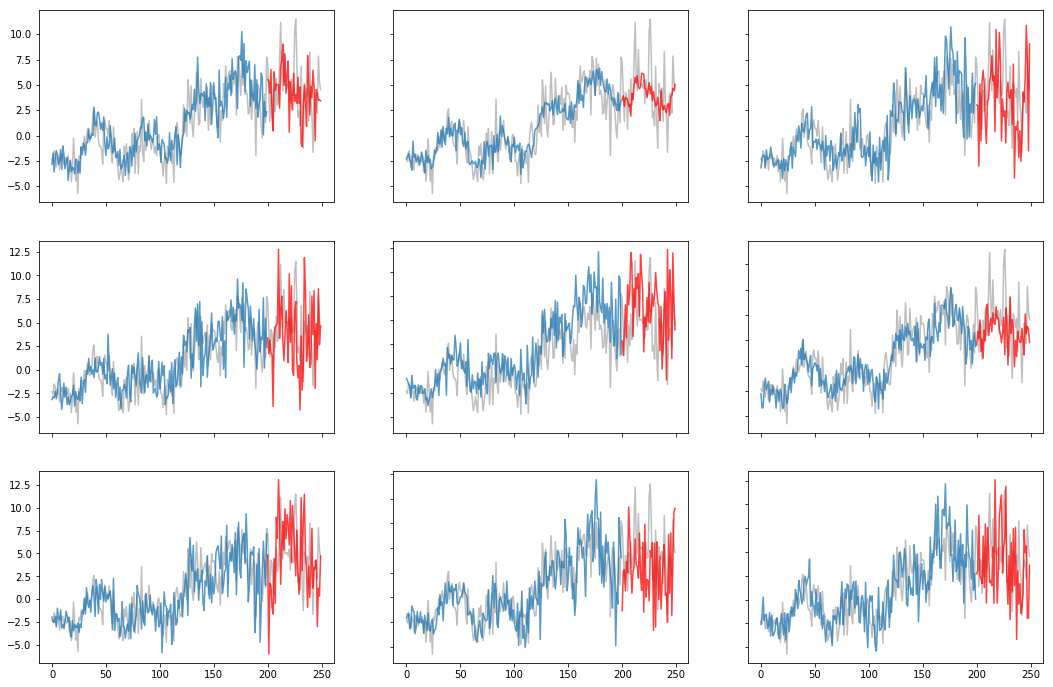

In [55]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = [18, 12])

for i in range(3):
  for j in range(3):
    
    # Define the model
    # Add a second output parameter, which will be the heteroscedasticity
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(1 + 1),
        tfp.layers.DistributionLambda(
            lambda t: tfd.Normal(
                loc = t[...,:1],
                scale = 1e-3 + tf.math.softplus(0.01 * t[...,1:])
            )
        )
    ])


    # Do inference.
    # In this case, x is simply a sequence from 1..250
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), loss=negloglik)
    model.fit(xtrain, ytrain, epochs=500, verbose=False)

    # Make predictions.
    yhat_train = model(xtrain)
    yhat_test = model(xtest)

    # Visualise the results
    axs[i,j].plot(range(250), y, color='grey', alpha=0.5, label = "groundtruth")
    axs[i,j].plot(range(200), yhat_train.sample(), alpha=0.75, label = 'training predictions')
    axs[i,j].plot(range(200,250), yhat_test.sample(), alpha=0.75, color = 'red', label = 'test predictions')

  
for ax in axs.flat:
  ax.label_outer()

plt.show()

The randomness of this is massively obvious now. We are getting wildly different ranges of variability across runs. What I am not sure about is whether this is variation in the model which is learned on each run, or whether this is the natural variability in the final distribution and perhaps the final distribution is the same in each case, but the variability we are observing is arising from independent draws from this learned distribution????

Let's find out. We'll copy and paste from above, but print the learned distributions mean and variability and the independent samples mean and variability.

In [61]:
for i in range(3):
  for j in range(3):
    
    # Define the model
    # Add a second output parameter, which will be the heteroscedasticity
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(1 + 1),
        tfp.layers.DistributionLambda(
            lambda t: tfd.Normal(
                loc = t[...,:1],
                scale = 1e-3 + tf.math.softplus(0.01 * t[...,1:])
            )
        )
    ])


    # Do inference.
    # In this case, x is simply a sequence from 1..250
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), loss=negloglik)
    model.fit(xtrain, ytrain, epochs=500, verbose=False)

    # Make predictions.
    yhat_train = model(xtrain)
    yhat_test = model(xtest)
    
    print("Training set (mu, sigma) = ({:.3f}, {:.3f})".format(np.mean(yhat_train.mean()), np.mean(yhat_train.stddev())))
    print("Test set (mu, sigma) = ({:.3f}, {:.3f})".format(np.mean(yhat_test.mean()), np.mean(yhat_test.stddev())))
    print("\n--")


Training set (mu, sigma) = (0.258, 0.876)
Test set (mu, sigma) = (3.133, 1.123)

--
Training set (mu, sigma) = (-0.629, 1.663)
Test set (mu, sigma) = (1.094, 3.063)

--
Training set (mu, sigma) = (0.526, 0.933)
Test set (mu, sigma) = (3.683, 1.258)

--
Training set (mu, sigma) = (1.012, 1.655)
Test set (mu, sigma) = (4.796, 3.097)

--
Training set (mu, sigma) = (0.876, 1.714)
Test set (mu, sigma) = (4.534, 3.176)

--
Training set (mu, sigma) = (0.846, 1.625)
Test set (mu, sigma) = (4.436, 3.052)

--
Training set (mu, sigma) = (0.571, 1.600)
Test set (mu, sigma) = (3.852, 2.995)

--
Training set (mu, sigma) = (0.673, 1.660)
Test set (mu, sigma) = (4.166, 3.092)

--
Training set (mu, sigma) = (1.190, 1.652)
Test set (mu, sigma) = (5.188, 3.112)

--


Hmmm, there is definitely a bit of variability here from one run to the next. But I think what we are seeing here is the natural sampling variance from the learned distribution. In all runs, I think the learned distribution is pretty much the same, and it is just the probabilistic nature of sampling that is giving rise to the variability. So all-in-all, very happy with this result!

### Case 4: Regularisation  

Finally, let's add some regularisation to our network, then we'll plot a range of posterior predictions. I am going to run through six different regularisation constants:

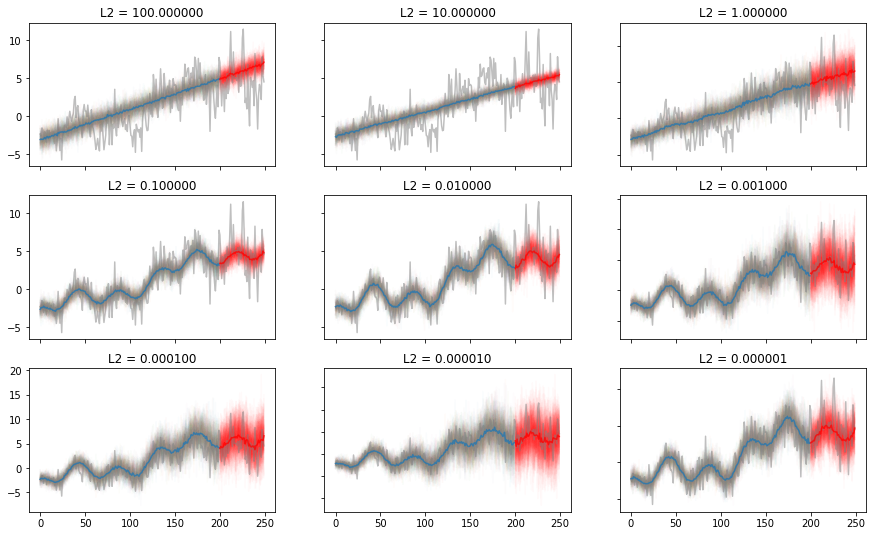

In [83]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = [15, 9])

eps = 0
for i in range(3):
  for j in range(3):
    
    eps += 1
    L2_CONSTANT = 1000 * (0.1 ** eps)
    
    # Define the model
    # Add a second output parameter, which will be the heteroscedasticity
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(1 + 1, 
                              kernel_regularizer=tf.keras.regularizers.l2(L2_CONSTANT)),
        tfp.layers.DistributionLambda(
            lambda t: tfd.Normal(
                loc = t[...,:1],
                scale = 1e-3 + tf.math.softplus(0.01 * t[...,1:])
            )
        )
    ])


    # Do inference.
    # In this case, x is simply a sequence from 1..250
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), loss=negloglik)
    model.fit(xtrain, ytrain, epochs=500, verbose=False)

    # Make predictions.
    yhat_train = model(xtrain)
    yhat_test = model(xtest)

    # Draw samples
    posterior_train = yhat_train.sample(100)
    posterior_test = yhat_test.sample(100)

    # Visualise the results
    # Plot posterior samples
    for k in range(100):
      axs[i,j].plot(range(200), posterior_train[k,...], alpha=0.02)
      axs[i,j].plot(range(200,250), posterior_test[k,...],color='red', alpha=0.02)

    # Plot the Posterior Means
    axs[i,j].plot(range(250), y, color='grey', alpha=0.5, label='ground truth')
    axs[i,j].plot(range(200), np.mean(posterior_train, axis=0), alpha=0.75, label = 'training predictions')
    axs[i,j].plot(range(200,250), np.mean(posterior_test, axis=0), alpha=0.75, color = 'red', label = 'test predictions')
    axs[i,j].title.set_text("L2 = {:.6f}".format(L2_CONSTANT))

for ax in axs.flat:
  ax.label_outer()

plt.show()

That's pretty cool. The effect of the regularisation is very clear, both in terms of the bias in the predictions and the range of uncertainties. 

The nicest thing about this though, is that this is starting to feel really Bayesian. We've managed to learn the distribution, account for all of the features in this dataset (trend, seasonality, heteroscdasticity) and draw posterior samples. Awesome!

Tomorrow, we might see if we can extend on this and remove the covariates. Can we embed a wave-like function into our distribution so that it learns the seasonality itself? Or, can we define a couple of different Gaussian Process kernels to learn the trend and seasonality? If I can figure that out - then I will be stoked and we are on our way to doing some very, very interesting work!